## Try diffetent types of preprocessing(support code for preprocessing.py)

In [1]:
from psutil import cpu_count

In [2]:
cpu_count() // 2 + 4

12

In [3]:
import config
import pandas as pd
import numpy as np

In [4]:
cfg = config.Config(80)

In [5]:
train_curated = pd.read_csv(cfg.csv_file['train_curated'])
train_noisy = pd.read_csv(cfg.csv_file['train_noisy'])
train_df = pd.concat([train_curated, train_noisy], sort=True, ignore_index=True)
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [6]:
test_df = pd.read_csv(cfg.csv_file['sample_submission'])
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,426eb1e0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,428d70bb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4292b1c9.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,429c5071.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
labels = test_df.columns[1:].tolist()

In [8]:
print("Classes amount: ", len(labels))

Classes amount:  80


In [9]:
y_train = np.zeros((len(train_df), cfg.num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(24785, 80)

In [10]:
import librosa
import librosa.display
import random
from tqdm import tqdm_notebook
import IPython
import IPython.display
import matplotlib.pyplot as plt

In [11]:
def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft+10,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels

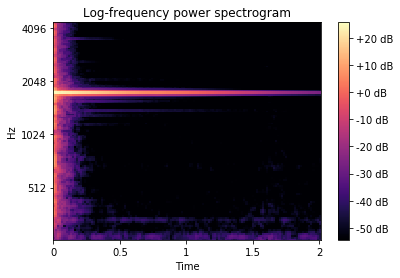

128

In [13]:
len(read_as_melspectrogram(cfg, cfg.dataset['train_curated']/'ef897dd7.wav', True, True))

In [14]:
train_curated[train_curated['fname'] ==  'ef897dd7.wav']

,fname,labels
4648,ef897dd7.wav,Glockenspiel


In [1]:
from preprocessing import Audio_preprocessor
from config import Config
from model import MainModel

In [2]:
cfg = Config(80)

In [3]:
preprocessor = Audio_preprocessor(cfg, trim_long_data=False)

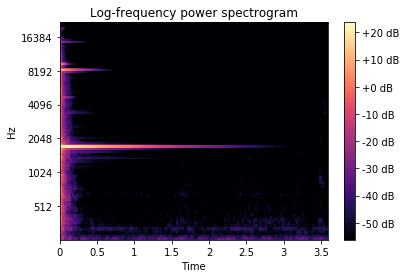

In [4]:
mels = preprocessor.preprocess(cfg.dataset['train_curated']/'ef897dd7.wav')

In [12]:
model_obj = MainModel('Simple', num_classes=cfg.num_classes)

SimpleModel(
  (conv): Sequential(
    (0): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): ConvBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
 